In [39]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
import matplotlib.pyplot as plt
import numpy as np
from math import floor

In [3]:
from matplotlib import rcParams

In [4]:
%matplotlib inline
rcParams.update({'font.size': 18, 'text.usetex': True})

In [5]:
# make qutip available in the rest of the notebook
from qutip import *

In [6]:
N = 15         # number of cavity fock states
# intial state
psi0 = tensor(basis(N,0), basis(2,0))    # start with an excited atom
psi1 = coherent(N, 0.85)

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), sigmam())
sx = tensor(qeye(N), sigmax())
sy = tensor(qeye(N), sigmay())
sz = tensor(qeye(N), sigmaz())

In [7]:
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 1.0  * 2 * np.pi  # atom frequency
g  = 0.1 * 2 * np.pi  # coupling strength

# Rabi Model Hamiltonian decomposed into three parts:
H_list = [wc * a.dag() * a + 0.5 * wa * sz,
          g * (a.dag() * sm.dag() + a * sm),
          g * (a * sm.dag() + a.dag() * sm)]
H = sum(H_list)

In [51]:
T = 10
t_list0 = np.linspace(0, T, 1000)
t_list1 = np.linspace(0, len(H_list) * T, 1000)

In [52]:
n = len(H_list)
m = 4

(H_list[0] * (floor((m * t / T) % n) == 0)
 + H_list[1] * (floor((m * t / T) % n) == 1)
 + H_list[2] * (floor((m * t / T) % n) == 2))

NameError: name 't' is not defined

In [53]:
result0 = mesolve(H, psi0, t_list0, [], [sx, sy, sz, a.dag() * a, sm.dag() * sm])

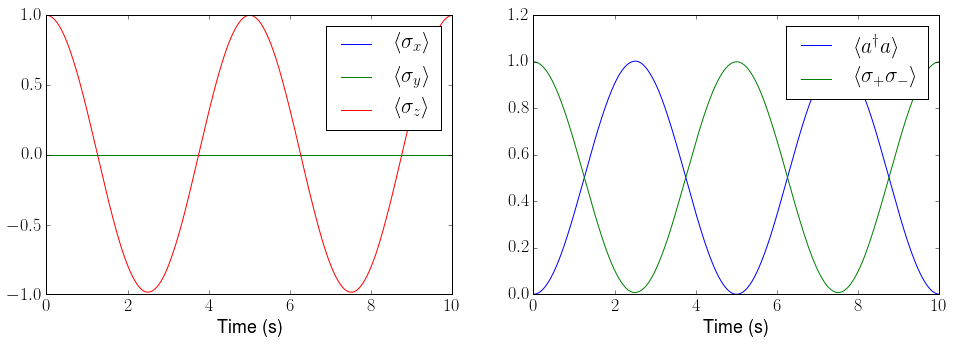

In [69]:
fig, axes = plt.subplots(1, 2, figsize = (16,5))
axes[0].plot(result0.times, result0.expect[0], label=r'$\langle \sigma_x \rangle$')
axes[0].plot(result0.times, result0.expect[1], label=r'$\langle \sigma_y \rangle$')
axes[0].plot(result0.times, result0.expect[2], label=r'$\langle \sigma_z \rangle$')
axes[0].legend()
axes[0].set_xlabel('Time (s)')

axes[1].plot(result0.times, result0.expect[3], label=r'$\langle a^\dagger a \rangle$')
axes[1].plot(result0.times, result0.expect[4], label=r'$\langle \sigma_+ \sigma_- \rangle$')
axes[1].legend()
axes[1].set_xlabel('Time (s)')

In [70]:
m = 30
def H0_coeff(t, args):
    n = len(H_list)
    return 1.0 * floor((m * t / T) % n) == 0

def H1_coeff(t, args):
    n = len(H_list)
    return 1.0 * floor((m * t / T) % n) == 1

def H2_coeff(t, args):
    n = len(H_list)
    return 1.0 * floor((m * t / T) % n) == 2

In [71]:
result1 = mesolve([[H_list[0], H0_coeff], [H_list[1], H0_coeff], [H_list[2], H0_coeff]],
                  psi0, t_list1, [], [sx, sy, sz, a.dag() * a, sm.dag() * sm])

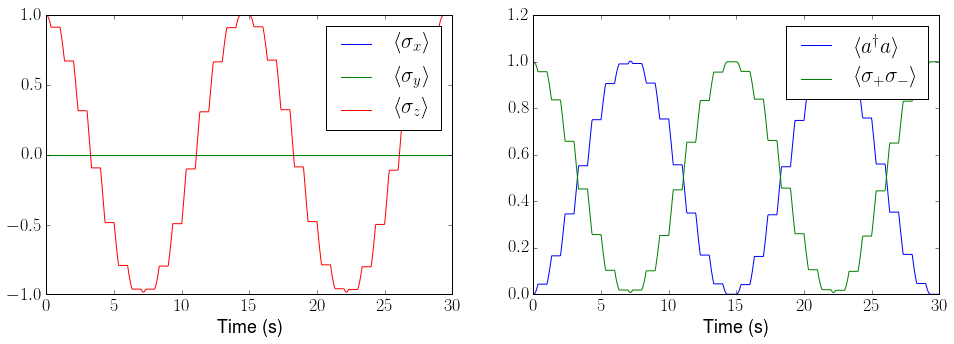

In [72]:
fig, axes = plt.subplots(1, 2, figsize = (16,5))
axes[0].plot(result1.times, result1.expect[0], label=r'$\langle \sigma_x \rangle$')
axes[0].plot(result1.times, result1.expect[1], label=r'$\langle \sigma_y \rangle$')
axes[0].plot(result1.times, result1.expect[2], label=r'$\langle \sigma_z \rangle$')
axes[0].legend()
axes[0].set_xlabel('Time (s)')

axes[1].plot(result1.times, result1.expect[3], label=r'$\langle a^\dagger a \rangle$')
axes[1].plot(result1.times, result1.expect[4], label=r'$\langle \sigma_+ \sigma_- \rangle$')
axes[1].legend()
axes[1].set_xlabel('Time (s)')